Author : Nopparoek Pimsan

# Battle of Neighborhood in Bangkok, Thailand 
## (IBM Datascience Capstone Project)

# Introduction

Bangkok is the capital and most important city in Thailand, with a population of over eight million people. Thanks to its growing economic development and massive popularity as an international tourist destination, it become one of southeast Asia's most influential and modern cities.

Millions of tourist come here every year to enjoy the beautiful seightseeing, heritage sites, hanging around the city and visit shopping centers and one important thing is the thai tranditional food which is always easy to find and try on it. This is a key of success who those want to start the business about the food or others likes Thai Spa to serve for foreigners. 


# Business Problems

In part of Restaurant or food and beverage business, so there are always unlimited possibilities for those who want to open their own restaurants. But the biggest challenge they are facing is which location is the best that relatively small competition, large passenger, tourists flow and good surrounding resources.

To solve this inquiry, this project is going to do neighborhood segmentation in Bangkok using a popular clustering techniques, and try to figure out a solution for potential restaurant investors.


# Data 

The neighborhood segmentation in Bangkok, the neighborhood data is scraped by using BeautifulSoup function from Wikipedia (https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok) to find out the districts in Bangkok, and corresponding coordinates are obtained by using GeoCoder. All data of venues in each neighborhoods is retrieved by Foursquare API. 

There are 51 districts in Bangkok is considered and selected 80% to scope down the areas which are contained 926 venues with 166 different venue categories in Bangkok for further segmenting the neighborhoods.

# Methodologies

Several techniques are applied for data acquisition, data pre-processing and analytic model in Python as following.

## Data Acquisition

The official neighborhood list is retreived from Wikipedia (https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok) which scraped by using BeautifulSoup including Requests packages with python (jupyter notebook). The corresponding coordinates (Latitude & Longtitude) of each neighborhoods are obtained by using Geocoder and all venue information is retreived from Foursquare API.

In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import geocoder 
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

## Data Pre-processing

The official neighborhoods scraped from Wikipedia is cleaned to get 51 districts(neighborhoods) in Bangkok Thailand and converted to Neighborhood dataframe to getting the cooresponding coordinates.

### Get Neighborhood Function

In [32]:
# get neighborhood extracting by beautifulsoups
def getNeighborhood():
    req = requests.get("https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok")
    neighborhoods = BeautifulSoup(req.text)
    items = neighborhoods.find_all("tr")
    n_dict = {}
    for i in range(10, 51):
        try:
            n_dict["Neighborhood"].append(items[i].text)
        except:
            n_dict["Neighborhood"] = []
    return pd.DataFrame(n_dict)


### Getting Latitude and Longtitude Function 

In [48]:
# getting Latitude and Longtitude function
def get_latlng(neighborhood):
    lat_lng_coords = None       # initialize your variable to None
    
    while(lat_lng_coords is None):   # loop until you get the coordinates
        g = geocoder.arcgis('{}, Bangkok, Thailand'.format(neighborhood)) #Geodata Bangkok, Thailand
        lat_lng_coords = g.latlng
    
    return lat_lng_coords

#feature extraction from foursquare (Limit venue and radius from coordinates)
LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

#foursquare developer console  
CLIENT_ID = "RPLRMCDHJMHDARM1DBZC5M53Y5WVHI3AV5STQNBJC4QDP33D"
CLIENT_SECRET = "XVH5HLDCCQCYFMGO4HFG03JHGCATQTR4CRVSU5EHC4RHVB5P"
VERSION = "20180605"


### Getting nearby venue with limit 100 venues and 500 meters radius

In [68]:
#get nearyby venues list function 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):  ##
        print(name, lat, lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting common venues in each neighborhood area

In [50]:
#return most common venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[5:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Getting elbow plot to get the optimal number of clusters

In [51]:
## plot elbow method for K-nearest neighbor
def plot_elbow(w, h, kmeans):
    plt.figure(figsize = (w,h))
    plt.axvline(x=5, linestyle='-.', c="black")
    plt.plot(range(1,10),[k.inertia_ for k in kmeans], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

The official neighborhoods scraped from Wikipedia is cleaned to get 51 districts(neighborhoods) in Bangkok Thailand and converted to Neighborhood dataframe to getting the cooresponding coordinates.

In [66]:
neighborhoods = getNeighborhood()
temp = neighborhoods.values.tolist()
res = []

for i in temp:
    i = i[0]
    i = i.strip()
    i = i.split('\n')
    res.append(i[0])

neighborhoods = pd.DataFrame(res, columns =['Neighborhood'])
print(neighborhoods)

            Neighborhood
0            Bangkok Noi
1            Bangkok Yai
2              Bueng Kum
3              Chatuchak
4             Chom Thong
5              Din Daeng
6             Don Mueang
7                  Dusit
8            Huai Khwang
9            Khan Na Yao
10         Khlong Sam Wa
11            Khlong San
12           Khlong Toei
13                Lak Si
14           Lat Krabang
15             Lat Phrao
16              Min Buri
17             Nong Chok
18            Nong Khaem
19            Pathum Wan
20         Phasi Charoen
21            Phaya Thai
22          Phra Khanong
23           Phra Nakhon
24  Pom Prap Sattru Phai
25                Prawet
26            Rat Burana
27           Ratchathewi
28               Sai Mai
29        Samphanthawong
30           Saphan Sung
31                Sathon
32            Suan Luang
33           Taling Chan
34        Thawi Watthana
35             Thon Buri
36            Thung Khru
37        Wang Thonglang
38              Watthana


Once getting the neighborhood list, the correspoding are retreived from Geocoder which searching through ArcGIS to be further location references.

In [70]:
# Scape data from open-souce databases 
coords = [get_latlng(neighborhood) for neighborhood in neighborhoods["Neighborhood"].tolist()]
print("- finished scraping coordinates for all neiborhoods")
neighborhoods= pd.concat([neighborhoods, pd.DataFrame(columns=["Latitude", "Longitude"], data=coords)], axis=1)
bangkok_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
print("- finished scraping top 100 venues in each neighborhood")

- finished scraping coordinates for all neiborhoods
Bangkok Noi 13.762856514383884 100.47805047334089
Bangkok Yai 13.723341621729844 100.47620728964012
Bueng Kum 13.785468110587033 100.66949998834428
Chatuchak 13.82879045508281 100.55995626810454
Chom Thong 13.6773530465411 100.4841288694385
Din Daeng 13.769812500671947 100.55310819020877
Don Mueang 13.910502894143576 100.59494462030261
Dusit 13.777178519450672 100.52060462504397
Huai Khwang 13.776606134369842 100.57931866949542
Khan Na Yao 13.799069693034767 100.68258386790995
Khlong Sam Wa 13.859621351166709 100.70417463140188
Khlong San 13.730628019219125 100.50919903957964
Khlong Toei 13.708138097458345 100.58361281110649
Lak Si 13.88737454906186 100.57916912695174
Lat Krabang 13.723424549031336 100.78412279004868
Lat Phrao 13.8035387102816 100.60751297499417
Min Buri 13.81357494276773 100.73116121351
Nong Chok 13.855736976045307 100.86252872308881
Nong Khaem 13.705390376469154 100.3491773278302
Pathum Wan 13.736610194966943 100.52

The neighborhood coordinates and neighborhood names are cleaned and pre-processed, the venue informations sorted by each name and its corresponding coordinates are retrieved from FourSquare API that communicated through Web URL configured by CLIENT_ID, CLIENT_SECRET, VERSION, LATITUDE, LONGTITUDE, RADIUS amd LIMIT. The Radius is set to search the nearby neighborhood names which set default at 500 methers and limited 100 venues per each neighborhood. The venue information consists of Venue Name, Venue Location (Latitude and Longtitude coordinates, Venue Categories within the Radius and Limits.

In [71]:
print(f" There are {len(bangkok_venues.Neighborhood.unique())} neighborhoods in Bangkok, Thailand \n There are {vancouver_venues.shape[0]} observations in the dataframe.")
bangkok_venues

 There are 40 neighborhoods in Bangkok, Thailand 
 There are 926 observations in the dataframe.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bangkok Noi,13.762857,100.478050,Bangkok Noi Canal (คลองบางกอกน้อย),13.764990,100.476043,Canal
1,Bangkok Noi,13.762857,100.478050,บ้านเนินนม นมสด ขนมปังปิ้ง (Baan Neพn Nom),13.759726,100.477860,Dessert Shop
2,Bangkok Noi,13.762857,100.478050,Thon Buri Train Market (ตลาดรถไฟธนบุรี),13.760172,100.478949,Farmers Market
3,Bangkok Noi,13.762857,100.478050,Golden Place (โกลเด้น เพลซ),13.759775,100.480562,Supermarket
4,Bangkok Noi,13.762857,100.478050,ตลาดศาลาน้ำเย็น,13.761534,100.474134,Market
...,...,...,...,...,...,...,...
921,Yan Nawa,13.696239,100.542272,แสงสีรุ้ง,13.699445,100.541587,Chinese Restaurant
922,Yan Nawa,13.696239,100.542272,7-Eleven (เซเว่น อีเลฟเว่น),13.699195,100.543633,Convenience Store
923,Yan Nawa,13.696239,100.542272,Rumruay Pochana (ร่ำรวยโภชนา),13.699501,100.541553,Chinese Restaurant
924,Yan Nawa,13.696239,100.542272,The Deck,13.700613,100.542068,Breakfast Spot


## Data Exporatory Analysis

The Venue information, a categorical feature is transformed to numerical features by using One-Hot-Encoding. The frequency of each venue category in each neighborhood is calculated to be used as key features in neighborhood segmentation. The Top 10 most common venues category are identified for each neighborhood.

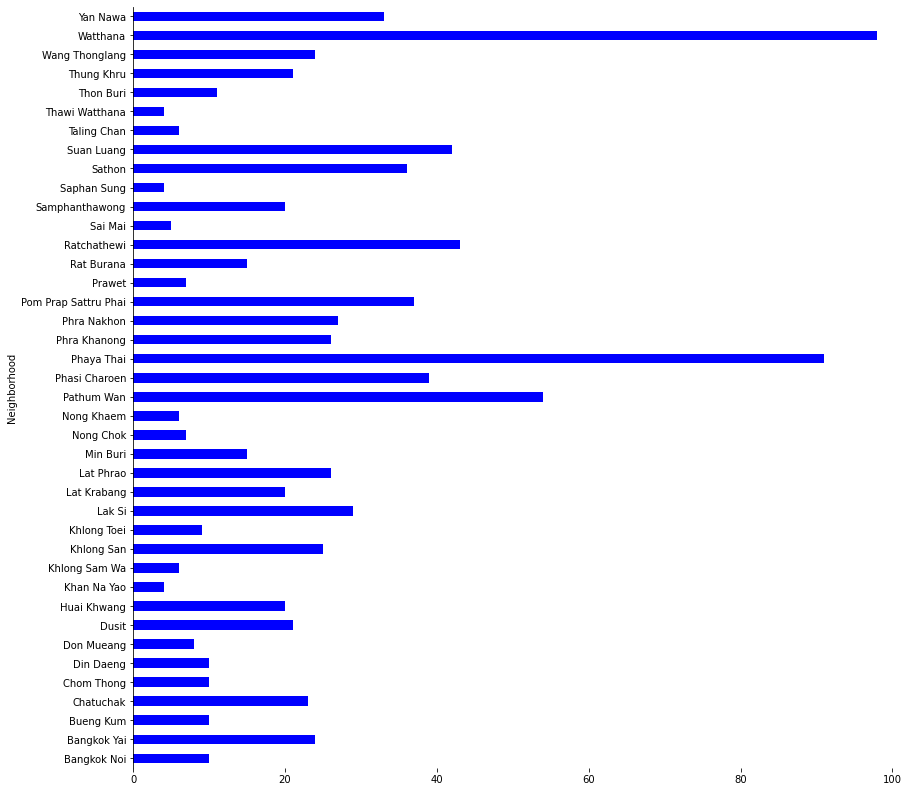

In [72]:
venues_counts = bangkok_venues[["Neighborhood", "Venue Category"]].groupby("Neighborhood", as_index=False).count()
ax = venues_counts.plot(figsize=(14, 14), x="Neighborhood", kind="barh", color='blue')

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()

# plt.savefig("count_bar.png")


In [73]:
# Apply one-hot encoding to Venue Category
ohe = OneHotEncoder(sparse=False, dtype=int)

bangkok_oht = pd.concat((bangkok_venues, pd.DataFrame(ohe.fit_transform(bangkok_venues[["Venue Category"]]),
                           columns=ohe.categories_[0])),
          axis=1)
bangkok_oht

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Accessories Store,Airport Service,Airport Terminal,...,Thai Restaurant,Theater,Toll Plaza,Tour Provider,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,Bangkok Noi,13.762857,100.478050,Bangkok Noi Canal (คลองบางกอกน้อย),13.764990,100.476043,Canal,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bangkok Noi,13.762857,100.478050,บ้านเนินนม นมสด ขนมปังปิ้ง (Baan Neพn Nom),13.759726,100.477860,Dessert Shop,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bangkok Noi,13.762857,100.478050,Thon Buri Train Market (ตลาดรถไฟธนบุรี),13.760172,100.478949,Farmers Market,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bangkok Noi,13.762857,100.478050,Golden Place (โกลเด้น เพลซ),13.759775,100.480562,Supermarket,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bangkok Noi,13.762857,100.478050,ตลาดศาลาน้ำเย็น,13.761534,100.474134,Market,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,Yan Nawa,13.696239,100.542272,แสงสีรุ้ง,13.699445,100.541587,Chinese Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
922,Yan Nawa,13.696239,100.542272,7-Eleven (เซเว่น อีเลฟเว่น),13.699195,100.543633,Convenience Store,0,0,0,...,0,0,0,0,0,0,0,0,0,0
923,Yan Nawa,13.696239,100.542272,Rumruay Pochana (ร่ำรวยโภชนา),13.699501,100.541553,Chinese Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
924,Yan Nawa,13.696239,100.542272,The Deck,13.700613,100.542068,Breakfast Spot,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group the common venues and nieghborhood area

In [74]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
bangkok_grouped = bangkok_oht.groupby('Neighborhood').mean().reset_index()

# Generate the top 10 most common venue categories in each neighborhood 
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangkok_grouped['Neighborhood']

for ind in np.arange(bangkok_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangkok_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted = neighborhoods_venues_sorted.set_index("Neighborhood")

In [75]:
colnames = neighborhoods_venues_sorted.columns.to_list()
bangkok_grouped = bangkok_grouped.set_index("Neighborhood")
neighborhood_names = vancouver_grouped.index.to_list()

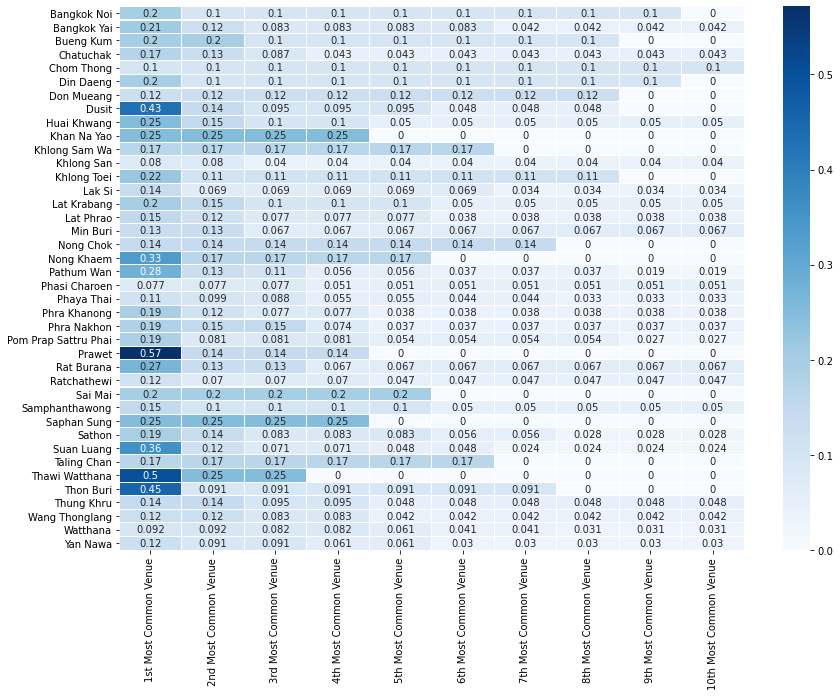

In [77]:
# Draw a heatmap to show probabilities 
heatmap_dict = {}
for i in range(len(colnames)):
    for j in range(len(neighborhood_names)+1):
        try:
            heatmap_dict[colnames[i]].append(
                bangkok_grouped.loc[neighborhood_names[j-1], neighborhoods_venues_sorted.loc[neighborhood_names[j-1], colnames[i]]])
        except:
            heatmap_dict[colnames[i]] = []
            
heatmap_df = pd.DataFrame(index=neighborhood_names, data=heatmap_dict)

plt.figure(figsize=(14, 10))
ax = sns.heatmap(heatmap_df, linewidths=.1, annot=True, cmap="Blues")

plt.savefig("heatmap.png")

In [78]:
## sort neighborhood venues
neighborhoods_venues_sorted.reset_index(inplace=True)
bangkok_grouped.reset_index(inplace=True)

### Model Development

The K-Mean unsupervised machine learning technique are selected to cluster similar neighborhoods, and Elbow method is applied to get the optimal number of cluster, and Folium is used to visualize those resulting clusters on the map.

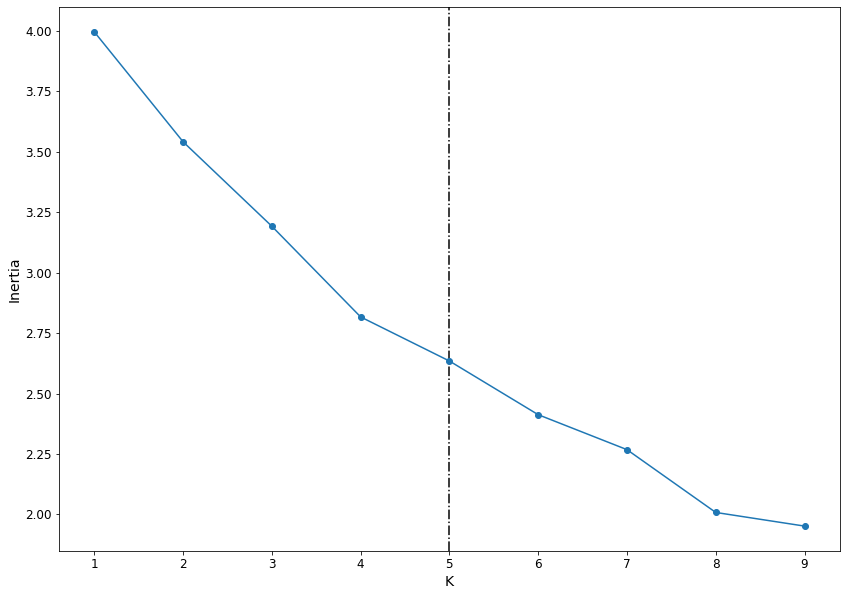

In [81]:
# Cluster neighborhood 
bangkok_grouped_clustering = bangkok_grouped.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue Latitude', 'Venue Longitude'])


# Use elbow methods to decide k
kmeans = list()
for k in range(1,10):
    kmeans.append(KMeans(n_clusters=k, random_state=0, ).fit(bangkok_grouped_clustering))
    
    
plot_elbow(14,10, kmeans)
# plt.savefig("elbow_plot.png")


In [84]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangkok_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
bangkok_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [85]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.sort_values("Cluster Labels")
neighborhoods_venues_sorted.to_csv("neighborhood_venues_sorted.csv")
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Bangkok Noi,Convenience Store,Dessert Shop,Supermarket,Intersection,History Museum,Train Station,Farmers Market,Canal,Market,Film Studio
36,0,Thung Khru,Convenience Store,Café,Fast Food Restaurant,Noodle House,Sushi Restaurant,Food Court,Mobile Phone Shop,Coffee Shop,Shipping Store,Bus Stop
33,0,Taling Chan,Soccer Field,Floating Market,Convenience Store,Noodle House,Pier,Seafood Restaurant,Donut Shop,Fast Food Restaurant,Farmers Market,Electronics Store
5,0,Din Daeng,Convenience Store,Soccer Field,Bus Stop,Hotel,Som Tum Restaurant,Food Court,Park,Sports Club,Stadium,Film Studio
30,0,Saphan Sung,Cupcake Shop,Convenience Store,Japanese Restaurant,Stadium,Dumpling Restaurant,Fishing Spot,Film Studio,Fast Food Restaurant,Farmers Market,Electronics Store
22,0,Phra Khanong,Convenience Store,Fast Food Restaurant,Hotel,Italian Restaurant,Ice Cream Shop,Beer Bar,Pharmacy,Residential Building (Apartment / Condo),Coffee Shop,Noodle House
14,0,Lat Krabang,Convenience Store,Noodle House,Ice Cream Shop,Thai Restaurant,Café,Market,Gym / Fitness Center,Soup Place,Park,Dumpling Restaurant
35,1,Thon Buri,Noodle House,Seafood Restaurant,Fried Chicken Joint,Train Station,Bus Stop,BBQ Joint,Flea Market,Duty-free Shop,Film Studio,Fast Food Restaurant
32,1,Suan Luang,Noodle House,Asian Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Bakery,Shopping Mall,Farmers Market,Café,Som Tum Restaurant
31,1,Sathon,Noodle House,Asian Restaurant,Dessert Shop,Chinese Restaurant,Convenience Store,Thai Restaurant,Bakery,Shopping Mall,Coffee Shop,Farmers Market


In [86]:
# clusters with lots of restaurants
neighborhoods_venues_sorted[neighborhoods_venues_sorted["Cluster Labels"].isin([1,2])]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,1,Thon Buri,Noodle House,Seafood Restaurant,Fried Chicken Joint,Train Station,Bus Stop,BBQ Joint,Flea Market,Duty-free Shop,Film Studio,Fast Food Restaurant
32,1,Suan Luang,Noodle House,Asian Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Bakery,Shopping Mall,Farmers Market,Café,Som Tum Restaurant
31,1,Sathon,Noodle House,Asian Restaurant,Dessert Shop,Chinese Restaurant,Convenience Store,Thai Restaurant,Bakery,Shopping Mall,Coffee Shop,Farmers Market
26,1,Rat Burana,Thai Restaurant,Intersection,Noodle House,Som Tum Restaurant,Hotpot Restaurant,Asian Restaurant,Harbor / Marina,Gym / Fitness Center,Convenience Store,Bistro
24,1,Pom Prap Sattru Phai,Noodle House,Convenience Store,Chinese Restaurant,Café,Dim Sum Restaurant,Dessert Shop,Steakhouse,Asian Restaurant,History Museum,Museum
23,1,Phra Nakhon,Thai Restaurant,Noodle House,Hostel,Asian Restaurant,Bakery,Dumpling Restaurant,Coffee Shop,Park,Convenience Store,Museum
18,1,Nong Khaem,Thai Restaurant,Market,Spa,Noodle House,Café,Wings Joint,Film Studio,Fast Food Restaurant,Farmers Market,Electronics Store
17,1,Nong Chok,Flea Market,Park,Noodle House,Convenience Store,Asian Restaurant,Shopping Mall,Other Repair Shop,Fast Food Restaurant,Farmers Market,Electronics Store
19,1,Pathum Wan,Noodle House,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Som Tum Restaurant,Café,BBQ Joint,Coffee Shop,Shopping Mall,Seafood Restaurant
1,1,Bangkok Yai,Noodle House,Dessert Shop,Farmers Market,Asian Restaurant,Coffee Shop,Thai Restaurant,BBQ Joint,Soup Place,Seafood Restaurant,Chinese Restaurant


In [87]:
# Clusters with less amount of restaurants
neighborhoods_venues_sorted[neighborhoods_venues_sorted["Cluster Labels"].isin([0,3,4])]


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Bangkok Noi,Convenience Store,Dessert Shop,Supermarket,Intersection,History Museum,Train Station,Farmers Market,Canal,Market,Film Studio
36,0,Thung Khru,Convenience Store,Café,Fast Food Restaurant,Noodle House,Sushi Restaurant,Food Court,Mobile Phone Shop,Coffee Shop,Shipping Store,Bus Stop
33,0,Taling Chan,Soccer Field,Floating Market,Convenience Store,Noodle House,Pier,Seafood Restaurant,Donut Shop,Fast Food Restaurant,Farmers Market,Electronics Store
5,0,Din Daeng,Convenience Store,Soccer Field,Bus Stop,Hotel,Som Tum Restaurant,Food Court,Park,Sports Club,Stadium,Film Studio
30,0,Saphan Sung,Cupcake Shop,Convenience Store,Japanese Restaurant,Stadium,Dumpling Restaurant,Fishing Spot,Film Studio,Fast Food Restaurant,Farmers Market,Electronics Store
22,0,Phra Khanong,Convenience Store,Fast Food Restaurant,Hotel,Italian Restaurant,Ice Cream Shop,Beer Bar,Pharmacy,Residential Building (Apartment / Condo),Coffee Shop,Noodle House
14,0,Lat Krabang,Convenience Store,Noodle House,Ice Cream Shop,Thai Restaurant,Café,Market,Gym / Fitness Center,Soup Place,Park,Dumpling Restaurant
34,3,Thawi Watthana,Soccer Field,Gym,Baseball Field,Dumpling Restaurant,Flea Market,Fishing Spot,Film Studio,Fast Food Restaurant,Farmers Market,Electronics Store
25,4,Prawet,Convenience Store,Noodle House,Comfort Food Restaurant,Halal Restaurant,Wings Joint,Dumpling Restaurant,Fishing Spot,Film Studio,Fast Food Restaurant,Farmers Market


In [93]:
# Get the latitude and longitude of Bangkok, Thailand
address = 'Bangkok, Thailand'

geolocator = Nominatim(user_agent="vc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok, Thailand are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok, Thailand are 13.7544238, 100.4930399.


In [94]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangkok_grouped['Neighborhood Latitude'], bangkok_grouped['Neighborhood Longitude'], bangkok_grouped['Neighborhood'], bangkok_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('bangkok_neighborhood_clustering.html')

### Result

The neighborhood has been clustered into 5 groups based on venues category and numbers of venue in each neighborhood areas. This is useful about the density of the restaurants, convenience stores, bars, fitnesses and others for further consideration on the proper area that would go on business. 

## Discussion

Neighborhoods in cluster 1 (purple) and cluster 2 (blue) are full of different kinds of restraurants. Thai restaurant and noodle houses are mostly located in cluster 1 while convenience stores are located in cluster 2. Cluster 1 which almost downtown of Bangkok has a high volume of people flow and relative large competition while cluster 2 is a little far from downtown but will have less rents. Other clusters have less restaurant but cluster 3 has a plenty of convenience stores and some of football fields which are a good place to open gym. Therefore if you have enough money, I would recommand you to open restaurants in neighborhoods closer to downtown in cluster 1 such a Downtown, Wattana, Phayathai and chatuchak district. But if you don’t have enough money and want to have less stress of peer competition, I would recommand you to open restaurants in neighborhoods relatively from Downtown in cluster 1 or other neighborhoods in cluster 2 or cluster 3.

In [92]:
from IPython.core.display import HTML
HTML(map_clusters._repr_html_())

## Conclusion 

This project applied K-means unsupervised machine learning to successfully segmented 41 neighborhood areas into 5 clusters. Some useful suggestions on opening restuarnat or others based on teh cluster result.

More analysis can be done using more information such as neighborhoods' GDP population, density and also the tourist flow.